In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


In [3]:
df = pd.read_csv('csv/helpdesk_customer_tickets_translated.csv')
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_translated,body_translated
333,2266821968717,Sofortige Unterstützung erforderlich: Problem ...,Sehr geehrtes Kundenserviceteam des Tech Onlin...,"Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Incident,Product Support,high,de,Tech Online Store,Technical Support,Software Bug,Hardware Failure,Urgent Issue,Problem Resolution,Customer Service,IT Support,NaN,NaN,Immediate assistance needed: Unresponsive touc...,"Dear Tech Online Store Customer Service Team,\..."
1102,6516276082845,Dringend: Netgear Switch GS108 Konnektivitätsp...,"Sehr geehrter Kunde des Tech Online Stores,\n\...","Sehr geehrte(r) <name>,\n\nvielen Dank, dass S...",Incident,Product Support,high,de,Tech Online Store,Technical Support,Network Issue,Service Disruption,Problem Resolution,Hardware Failure,Urgent Issue,Product Support,NaN,NaN,Urgent: Netgear Switch GS108 connectivity issue,"Dear Tech Online Store Customer,\n\nI hope thi..."
310,2155354941770,Solicitud para actualizar IntelliJ IDEA para m...,"Estimado equipo de soporte al cliente,\n\nEspe...","Estimado <name>,\n\nGracias por comunicarte co...",Change,Product Support,medium,es,Software Development Company,Product Support,Technical Guidance,Software Bug,Feature Request,Problem Resolution,Customer Service,NaN,NaN,NaN,Request to update IntelliJ IDEA to improve fea...,"Dear Customer Support Team,\n\nI hope this mes..."


In [4]:
# rmeove subject and body fields and place subject_translated and body_translated in its place
df.drop(columns=['subject', 'body'], inplace=True)


In [8]:
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index("subject_translated")))
cols.insert(2, cols.pop(cols.index("body_translated")))
print(cols)

['id', 'subject_translated', 'body_translated', 'answer', 'type', 'queue', 'priority', 'language', 'business_type', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9']


In [12]:
df = df[cols]
df.sample(3)

KeyError: "['subject_translated', 'body_translated'] not in index"

In [11]:
df = df.rename(columns={'subject_translated': 'subject', 'body_translated': 'body'})

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
325,2235786953129,Urgent: Frequent Network Drops Issue,"Dear Customer Support,\n\nWe are experiencing ...",Subject: Re: Urgent: Frequent Network Drops Is...,Incident,IT Support,high,en,IT Services,Network Issue,Technical Support,Urgent Issue,Problem Resolution,NaN,NaN,NaN,NaN,NaN
699,3946412026749,Intermittent connectivity issues with Cisco ro...,"Dear Customer Service Team,\n\nI am writing to...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Incident,Technical Support,medium,de,IT Services,Technical Support,Network Issue,IT Support,Incident Report,Problem Resolution,Service Disruption,Performance Tuning,NaN,NaN
317,2203179979407,Dell XPS 13 9310 performance issue,"Hi, I have noticed performance issues with my ...","Hola, intenta reiniciar y asegurarte de que to...",Incident,Technical Support,low,es,Tech Online Store,Performance Tuning,Technical Support,Product Support,System Maintenance,NaN,NaN,NaN,NaN,NaN


In [13]:
df.sample(3)


,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
156,1571851244129,Company network problem,"Dear Customer Support,\n\nI am writing to repo...",Asunto: Re: Problema de red de la empresa\n\nE...,Incident,IT Support,high,es,IT Services,Network Issue,Technical Support,Service Disruption,Problem Resolution,IT Support,NaN,NaN,NaN,NaN
440,2714614005441,Support request for Cisco Router ISR4331,"Dear IT Services Support Team,\n\nI hope this ...",Betreff: Re: Supportanfrage für Cisco Router I...,Change,Technical Support,high,de,IT Services,Technical Support,IT Support,Network Issue,System Maintenance,Problem Resolution,Technical Guidance,NaN,NaN,NaN
656,3712017558900,Urgent: Network Cut,"Dear IT Services Support Customer,<br><br>I ho...","Estimado <name>,\n\nGracias por contactarnos r...",Problem,IT Support,high,es,IT Services,Service Disruption,Network Issue,Technical Support,Incident Report,Urgent Issue,Problem Resolution,Technical Guidance,NaN,NaN


### **Analysis**
- While the model accuracy and precision comes out to be very good, when testing from user perspective, I find that the output by the model is not as accurate as I'd want 
- Due to keyword importance conflicts, I removed type and queue and just added the processed text (subject and body) as feature for the model
- After analysis, I find that the words present in the tags can also help the model to better classify

In [14]:
# combine all tags to one column, ignore tags with NaN tage 1-9
df['tags'] = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9']].apply(lambda x: ' '.join(x.dropna()), axis=1)
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tags
943,5344841403801,Billing Issues with Adobe Photoshop,"Dear Online Store Support,\n\nI hope this mess...","Cher <name>,\n\nMerci de nous avoir contactés ...",Problem,Billing and Payments,medium,fr,Tech Online Store,Billing Issue,Payment Processing,Customer Service,Account Assistance,Technical Support,NaN,NaN,NaN,NaN,Billing Issue Payment Processing Customer Serv...
93,1340436429524,AWS Deployment Issues,"Dear Customer Support Team,\n\nI am writing to...","Cher <name>,\n\nMerci de nous avoir contactés ...",Problem,Product Support,medium,fr,IT Services,Technical Support,Service Disruption,Urgent Issue,Problem Resolution,IT Support,Incident Report,System Maintenance,NaN,NaN,Technical Support Service Disruption Urgent Is...
322,2225506870954,Request to update printer settings,"Dear Tech Online Store Support,\n\nI am writin...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Change,Product Support,medium,de,Tech Online Store,Technical Support,Product Support,Software Bug,Technical Guidance,NaN,NaN,NaN,NaN,NaN,Technical Support Product Support Software Bug...


In [15]:
df.shape

(1564, 19)

In [16]:
df.drop(['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'tag_9'], axis=1, inplace=True)

In [17]:
df.sample(5)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
1332,8145896728057,Urgent: Overheating and battery drain issue on...,"Dear Customer Service, I am writing to report ...","Estimado <name>,\n\nGracias por contactarnos. ...",Problem,Product Support,high,es,Tech Online Store,Technical Support Hardware Failure Urgent Issu...
1151,6853375815312,Cisco Router Failure,"Dear Customer Service,\n\nI am writing to info...","Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Service Outages and Maintenance,high,fr,IT Services,Technical Support Service Disruption Urgent Is...
1445,9074655762875,Inquiry About Economical AWS Management Altern...,"Hello Customer Support Team,\n\nI trust this m...","Hello <name>,\n\nThank you for contacting us r...",Request,Technical Support,high,en,IT Services,Technical Support Product Support Cost Managem...
639,3632406027401,Urgent Support Required: Battery Issues with M...,"Dear Customer Support Team,\n\nI am experienci...",Objet : Re : Support urgent requis : Problèmes...,Problem,Customer Service,high,fr,Tech Online Store,Technical Support Urgent Issue Hardware Failur...
454,2771749068576,Request for change to AWS management configura...,"Dear IT Support,\n\nI am writing to request a ...",Asunto: Re: Solicitud de cambio en la configur...,Change,Technical Support,high,es,IT Services,IT Support Technical Guidance Problem Resoluti...


### Tokenize and lemmatize function

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm')

# create function to preprocess text
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip().lower()
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(preprocessed_tokens)


/Users/kripa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [19]:
# preprocess the tags
df['tags'] = df['tags'].apply(preprocess_text)

In [20]:
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
53,1210593011543,Request for exchange due to connection problems,"Dear Customer Service Team,\n\nI hope you are ...",Betreff: Re: Anfrage zum Austausch aufgrund vo...,Change,Returns and Exchanges,low,de,Tech Online Store,return exchange product support technical supp...
512,2996574934417,Request for UI Components Update,"Dear Customer Support Team,\n\nI hope this mes...","Dear <name>,\n\nThank you for reaching out to ...",Change,Product Support,low,en,Software Development Company,technical support product support software bug...
23,1097064233070,Urgent: AWS Management Service Issues,"Dear IT Services Customer Support Team, \n\nI ...","Dear <name>,\n\nThank you for reaching out to ...",Incident,Technical Support,high,en,IT Services,support urgent issue service disruption incide...


In [21]:
df.dropna(subset=['subject', 'body'], inplace=True)

df['subject'] = df['subject'].apply(preprocess_text)
df['body'] = df['body'].apply(preprocess_text)

df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tags
641,3640603429382,problem set aw ec2 security group,dear customer service write seek assistance ...,"Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Problem,Sales and Pre-Sales,low,de,IT Services,technical support support network issue proble...
654,3700804769310,urgent update require jira software 8.20,dear customer support write urgently request...,"Estimado <name>,\n\nGracias por comunicarte co...",Change,Service Outages and Maintenance,high,es,IT Services,technical support service disruption urgent is...
1219,7291393439152,network configuration problem,dear service customer service contact reques...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Problem,Technical Support,medium,fr,IT Services,technical support network issue performance tu...


In [22]:
df['processed_text'] = df['subject'] + ' ' + df['body'] + ' ' + df['tags']

df_en = df.drop(columns=['language'])

In [23]:
df_en = df_en[['processed_text', 'type', 'queue', 'priority']]
df_en.sample(10)

,processed_text,type,queue,priority
333,immediate assistance need unresponsive touchsc...,Incident,Product Support,high
1237,billing problem adobe photoshop dear tech onli...,Problem,Billing and Payments,medium
1174,support request router cause network issue dea...,Incident,IT Support,high
262,billing discrepancy issue dear service support...,Incident,Billing and Payments,medium
1143,immediate assistance need resolve server outag...,Problem,Technical Support,high
1310,help need canon pixma mg3620 printing quality ...,Problem,Technical Support,medium
1276,assistance need wireless setup canon pixma mg3...,Request,Product Support,low
486,assistance require epson ecotank et-4760 print...,Incident,Product Support,medium
443,excel intermittent crashing issue dear support...,Problem,Technical Support,medium
613,plan maintenance notice dear customer support ...,Incident,Service Outages and Maintenance,low


### Data Visualization

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

high_priority = df_en[df_en.priority == 'high']
medium_priority = df_en[df_en.priority == 'medium']
low_priority = df_en[df_en.priority == 'low']

def tfidf_vectorizer(text):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(text)
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    return top_words

high_priority_top_words = tfidf_vectorizer(high_priority['processed_text'])
medium_priority_top_words = tfidf_vectorizer(medium_priority['processed_text'])
low_priority_top_words = tfidf_vectorizer(low_priority['processed_text'])

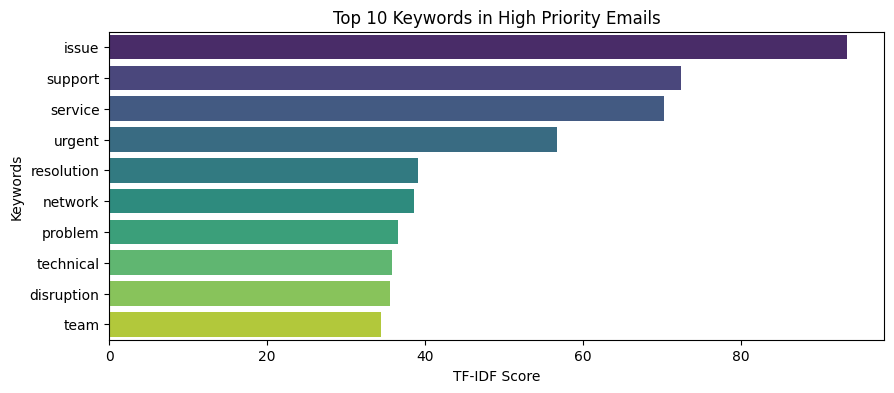

In [25]:
keywords, frequencies = zip(*high_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in High Priority Emails')
plt.show()

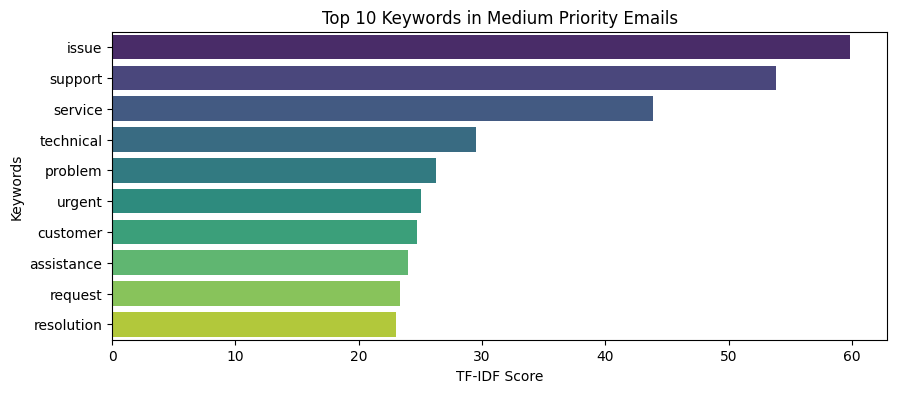

In [26]:
keywords, frequencies = zip(*medium_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Medium Priority Emails')
plt.show()

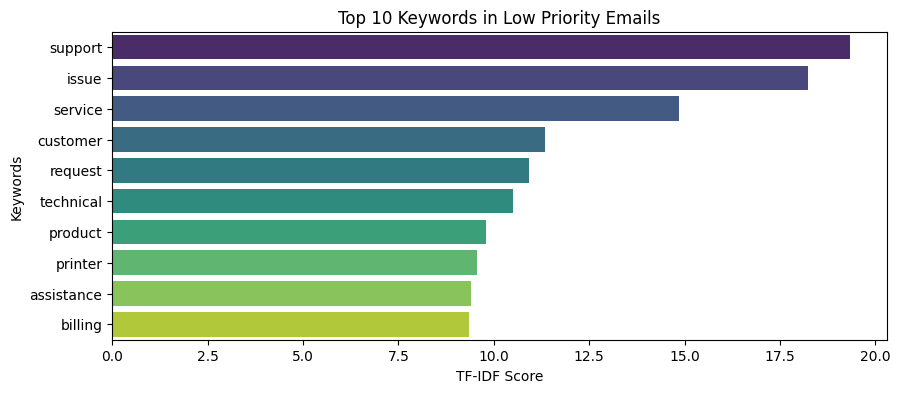

In [27]:
keywords, frequencies = zip(*low_priority_top_words)

plt.figure(figsize=(10, 4))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in Low Priority Emails')
plt.show()

### Model Training - Logistic Regression
**Why?** 
- Good for simple data 
- Fast

**Cons**
- Assumes linear relationship 
- Sensitive to outliers

In [28]:
df_en.shape

(1564, 4)

In [34]:
df_en['urgency'] = df['priority'].apply(lambda x: 'urgent' if x == 'high' else 'not_urgent')

In [35]:
df_en.sample(3)

,processed_text,type,queue,priority,urgency
523,immediate fix need zoom 5.11.0 crash dear cust...,Incident,Technical Support,high,urgent
667,dell xps 13 exchange request malfunction dear ...,Change,Returns and Exchanges,medium,not_urgent
684,billing assistance require dear customer suppo...,Request,Billing and Payments,medium,not_urgent


In [36]:
df_en[df_en.urgency == 'urgent'].shape

(787, 5)

In [37]:
df_en[df_en.urgency == 'not_urgent'].shape

(777, 5)

In [38]:
df_en.to_csv('csv/processed_tickets_en.csv', index=False)

In [43]:
X = df_en[['processed_text']]
y = df_en['urgency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'processed_text')
    ],
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [45]:
# Train the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  not_urgent       0.92      0.92      0.92       156
      urgent       0.92      0.92      0.92       157

    accuracy                           0.92       313
   macro avg       0.92      0.92      0.92       313
weighted avg       0.92      0.92      0.92       313



In [51]:
# Example prediction
example = pd.DataFrame({
    'processed_text': ['I need to know about my order status, not urgently.']
})

urgency = pipeline.predict(example)
print(f'Predicted urgency: {urgency[0]}')


Predicted urgency: urgent


### Model Training 

In [52]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

In [53]:
pipeline_svm.fit(X_train, y_train)

y_pred_svm = pipeline_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

  not_urgent       0.99      0.98      0.98       156
      urgent       0.98      0.99      0.98       157

    accuracy                           0.98       313
   macro avg       0.98      0.98      0.98       313
weighted avg       0.98      0.98      0.98       313



In [61]:
# Example prediction
example = pd.DataFrame({
    'processed_text': ['The server is down, critical failure!']
})

urgency = pipeline_svm.predict(example)
print(f'Predicted urgency: {urgency[0]}')

Predicted urgency: not_urgent
